# 测试学好的Q函数是否能表现得很好

实现目标：

1. 创建Agent， 并加载学习好的Q_net
2. 创建测试数据，使其可以分别输入IMM和Agent

In [196]:
from Agent import Agent
from Env import env

## 1. 加载Agent 

In [201]:
agent = Agent(T=5, cuda_id=3, test=True)
agent.load_Q_net("Q_net.model")

## 2.  数据生成

测试数据与训练数据同分布

In [174]:
from torch_geometric.data import Data
import torch
import numpy as np
import networkx as nx

## 3. Simulation 

In [159]:
def simulation_once(edge_index, edge_w, seed_list):
    import networkx as nx
    import ndlib.models.ModelConfig as mc
    import ndlib.models.epidemics as ep
    
    G = nx.DiGraph()
    G.add_edges_from(edge_index.T)
    
    model = ep.IndependentCascadesModel(G)
    
    # Model Configuration
    config = mc.Configuration()
    config.add_model_initial_configuration("Infected", seed_list)
    
    # Setting the edge parameters
    for e, w in zip(G.edges(), edge_w):
        config.add_edge_configuration("threshold", e, w)
    
    model.set_initial_status(config)
    
    while True:
        iteration = model.iteration()
        if iteration["node_count"][1] == 0:
            break
    
    return iteration["node_count"][2]

In [160]:
def simulation(edge_index, edge_w, seed_list, mc=100):
    from tqdm import tqdm
    import numpy as np
    spreads = []
    for i in tqdm(range(mc)):
        spreads.append(simulation_once(edge_index, edge_w, seed_list))
        
    return np.mean(spreads)

## 3. 方法比较 

In [161]:
def Q_infer(agent, Env, graph, K):
    Seed = []
    for i in range(K):
        action = agent.choose_action(graph)
        Seed.append(action)
        graph.node_tag[action] = 1
        
    return Seed

In [162]:
def IMM_infer(edge_index, edge_w, K):
    import os
    import time
    G = nx.DiGraph()
    G.add_edges_from(edge_index.T)
    with open(".imm_cache/attribute.txt", "w") as f:
        f.writelines("n={}\nm={}".format(G.number_of_nodes(), G.number_of_edges()))
    with open(".imm_cache/graph_ic.inf", "w") as f:
        for edge, weight in zip(edge_index.T, edge_w):
            f.writelines("{} {} {:.3f}\n".format(edge[0], edge[1], weight))
    
    t0 = time.time()
    imm_red = os.popen("./IMM/imm_discrete -dataset .imm_cache/ -k {} -model IC -epsilon 0.1".format(K))
    # print("{:.1f}ms".format((time.time()-t0)*1000))
    
    Seed = []
    Spread = 0
    for line in imm_red:
        if "opt_lower_bound" in line:
            Spread = float(line.split("=")[1].strip())
        if "seedSet" in line:
            seed_set = line.split("=")[1].strip().split(" ")
            Seed = [int(s) for s in seed_set]
    
    return Seed, Spread

### 测试1， 相同大小的网络

In [165]:
import matplotlib.pyplot as plt

100%|██████████| 500/500 [01:04<00:00,  7.76it/s]


550.572 548.062


100%|██████████| 500/500 [01:01<00:00,  8.12it/s]


591.852 582.752


100%|██████████| 500/500 [00:59<00:00,  8.46it/s]


609.156 601.05


100%|██████████| 500/500 [00:57<00:00,  8.66it/s]


629.682 611.602


100%|██████████| 500/500 [00:58<00:00,  8.59it/s]


643.93 619.778


100%|██████████| 500/500 [00:56<00:00,  8.87it/s]


658.102 630.432


100%|██████████| 500/500 [00:55<00:00,  8.95it/s]


669.188 633.948


100%|██████████| 500/500 [00:56<00:00,  8.85it/s]


681.984 641.876


100%|██████████| 500/500 [00:55<00:00,  9.07it/s]


695.39 652.194


100%|██████████| 500/500 [00:56<00:00,  8.91it/s]


704.976 653.61


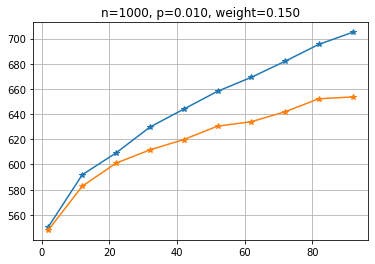

In [166]:
# ER graph
n = 1000
# p = np.log(n)/n
p = 0.01
weight=0.15
Env = env(graph_size=n, seed_size=n, p=p, weight=0.15)

mu, edge_index, edge_w, node_tag, done = Env.reset()
graph = Data(edge_index = torch.LongTensor(edge_index),
             mu = torch.Tensor(mu),
             edge_w = torch.Tensor(edge_w),
             node_tag = torch.Tensor(node_tag),
             num_nodes = n)

IMM_K = []
Q_K = []
K_range = range(2, 101, 10)
for K in K_range:
    imm_seed, imm_spread = IMM_infer(edge_index, edge_w, K=K)
    q_seed = Q_infer(agent, Env, graph, K=K)

    imm_simu = simulation(edge_index, edge_w, imm_seed, mc=500)
    q_simu = simulation(edge_index, edge_w, q_seed, mc=500)
    print(imm_simu, q_simu)
    
    IMM_K.append((imm_seed, imm_simu))
    Q_K.append((q_seed, q_simu))
    

plt.plot(K_range, [s[1] for s in IMM_K], "-*")
plt.plot(K_range, [s[1] for s in Q_K], "-*")
plt.grid(True)
plt.title("n={}, p={:.3f}, weight={:.3f}".format(n,p, weight))
plt.savefig("comparing_results/n_{}_p_{:.3f}_w_{:.3f}.pdf".format(n, p, weight))
plt.show()

100%|██████████| 500/500 [00:10<00:00, 47.16it/s]


15.414 16.078


100%|██████████| 500/500 [00:12<00:00, 40.91it/s]


66.394 61.39


100%|██████████| 500/500 [00:12<00:00, 38.71it/s]


103.67 92.892


100%|██████████| 500/500 [00:12<00:00, 40.01it/s]


131.666 106.958


100%|██████████| 500/500 [00:13<00:00, 37.47it/s]


156.864 127.11


100%|██████████| 500/500 [00:12<00:00, 38.98it/s]


175.762 137.228


100%|██████████| 500/500 [00:13<00:00, 37.27it/s]


195.944 147.566


100%|██████████| 500/500 [00:13<00:00, 37.71it/s]


211.522 155.678


100%|██████████| 500/500 [00:12<00:00, 39.02it/s]


226.778 160.322


100%|██████████| 500/500 [00:12<00:00, 40.59it/s]


241.376 149.702


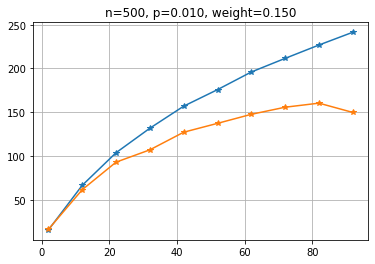

In [167]:
# ER graph
n = 500
# p = np.log(n)/n
p = 0.01
weight=0.15
Env = env(graph_size=n, seed_size=n, p=p, weight=weight)

mu, edge_index, edge_w, node_tag, done = Env.reset()
graph = Data(edge_index = torch.LongTensor(edge_index),
             mu = torch.Tensor(mu),
             edge_w = torch.Tensor(edge_w),
             node_tag = torch.Tensor(node_tag),
             num_nodes = n)

IMM_K = []
Q_K = []
K_range = range(2, 101, 10)
for K in K_range:
    imm_seed, imm_spread = IMM_infer(edge_index, edge_w, K=K)
    q_seed = Q_infer(agent, Env, graph, K=K)

    imm_simu = simulation(edge_index, edge_w, imm_seed, mc=500)
    q_simu = simulation(edge_index, edge_w, q_seed, mc=500)
    print(imm_simu, q_simu)
    
    IMM_K.append((imm_seed, imm_simu))
    Q_K.append((q_seed, q_simu))
    
plt.plot(K_range, [s[1] for s in IMM_K], "-*")
plt.plot(K_range, [s[1] for s in Q_K], "-*")
plt.grid(True)
plt.title("n={}, p={:.3f}, weight={:.3f}".format(n,p, weight))
plt.savefig("comparing_results/n_{}_p_{:.3f}_w_{:.3f}.pdf".format(n, p, weight))
plt.show()

100%|██████████| 500/500 [00:15<00:00, 33.04it/s]


34.918 33.564


100%|██████████| 500/500 [00:18<00:00, 27.65it/s]


114.878 103.394


100%|██████████| 500/500 [00:17<00:00, 28.80it/s]


155.662 138.83


100%|██████████| 500/500 [00:18<00:00, 27.55it/s]


181.094 163.576


100%|██████████| 500/500 [00:17<00:00, 28.45it/s]


205.926 185.056


100%|██████████| 500/500 [00:18<00:00, 26.94it/s]


226.68 189.78


100%|██████████| 500/500 [00:18<00:00, 27.65it/s]


243.822 199.738


100%|██████████| 500/500 [00:17<00:00, 29.29it/s]


257.596 211.364


100%|██████████| 500/500 [00:17<00:00, 28.36it/s]


272.178 213.332


100%|██████████| 500/500 [00:17<00:00, 28.75it/s]


286.418 210.22


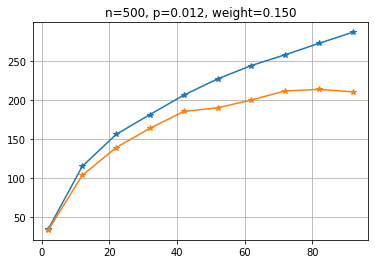

In [164]:
# ER graph
n = 500
p = np.log(n)/n
# p = 0.01
weight=0.15
Env = env(graph_size=n, seed_size=n, p=p, weight=weight)

mu, edge_index, edge_w, node_tag, done = Env.reset()
graph = Data(edge_index = torch.LongTensor(edge_index),
             mu = torch.Tensor(mu),
             edge_w = torch.Tensor(edge_w),
             node_tag = torch.Tensor(node_tag),
             num_nodes = n)

IMM_K = []
Q_K = []
K_range = range(2, 101, 10)
for K in K_range:
    imm_seed, imm_spread = IMM_infer(edge_index, edge_w, K=K)
    q_seed = Q_infer(agent, Env, graph, K=K)

    imm_simu = simulation(edge_index, edge_w, imm_seed, mc=500)
    q_simu = simulation(edge_index, edge_w, q_seed, mc=500)
    print(imm_simu, q_simu)
    
    IMM_K.append((imm_seed, imm_simu))
    Q_K.append((q_seed, q_simu))

plt.plot(K_range, [s[1] for s in IMM_K], "-*")
plt.plot(K_range, [s[1] for s in Q_K], "-*")
plt.grid(True)
plt.title("n={}, p={:.3f}, weight={:.3f}".format(n,p, weight))
plt.savefig("comparing_results/n_{}_p_{:.3f}_w_{:.3f}.pdf".format(n, p, weight))
plt.show()

100%|██████████| 500/500 [00:13<00:00, 37.06it/s]


19.582 17.678


100%|██████████| 500/500 [00:16<00:00, 31.05it/s]


42.832 39.288


100%|██████████| 500/500 [00:15<00:00, 32.25it/s]


61.662 56.72


100%|██████████| 500/500 [00:15<00:00, 31.89it/s]


75.612 65.528


100%|██████████| 500/500 [00:15<00:00, 31.75it/s]


92.004 75.242


100%|██████████| 500/500 [00:16<00:00, 31.03it/s]


101.51 83.858


100%|██████████| 500/500 [00:16<00:00, 30.48it/s]


111.546 96.902


100%|██████████| 500/500 [00:16<00:00, 29.85it/s]


117.832 99.942


100%|██████████| 500/500 [00:16<00:00, 30.54it/s]


129.85 103.496


100%|██████████| 500/500 [00:16<00:00, 30.04it/s]


134.71 105.946


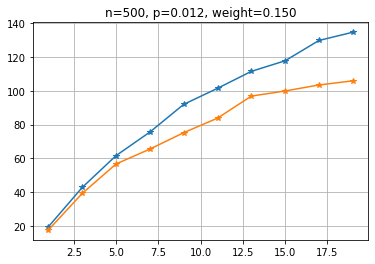

In [168]:
# ER graph
n = 500
p = np.log(n)/n
# p = 0.01
weight=0.15
Env = env(graph_size=n, seed_size=n, p=p, weight=weight)

mu, edge_index, edge_w, node_tag, done = Env.reset()
graph = Data(edge_index = torch.LongTensor(edge_index),
             mu = torch.Tensor(mu),
             edge_w = torch.Tensor(edge_w),
             node_tag = torch.Tensor(node_tag),
             num_nodes = n)

IMM_K = []
Q_K = []
K_range = range(1, 21, 2)
for K in K_range:
    imm_seed, imm_spread = IMM_infer(edge_index, edge_w, K=K)
    q_seed = Q_infer(agent, Env, graph, K=K)

    imm_simu = simulation(edge_index, edge_w, imm_seed, mc=500)
    q_simu = simulation(edge_index, edge_w, q_seed, mc=500)
    print(imm_simu, q_simu)
    
    IMM_K.append((imm_seed, imm_simu))
    Q_K.append((q_seed, q_simu))
    
plt.plot(K_range, [s[1] for s in IMM_K], "-*")
plt.plot(K_range, [s[1] for s in Q_K], "-*")
plt.grid(True)
plt.title("n={}, p={:.3f}, weight={:.3f}".format(n,p, weight))
plt.savefig("comparing_results/n_{}_p_{:.3f}_w_{:.3f}.pdf".format(n, p, weight))
plt.show()

100%|██████████| 500/500 [00:10<00:00, 48.39it/s]


9.122 9.578


100%|██████████| 500/500 [00:11<00:00, 43.68it/s]


24.442 23.412


100%|██████████| 500/500 [00:12<00:00, 41.36it/s]


36.978 34.84


100%|██████████| 500/500 [00:12<00:00, 40.41it/s]


47.434 38.45


100%|██████████| 500/500 [00:12<00:00, 40.34it/s]


56.236 47.756


100%|██████████| 500/500 [00:12<00:00, 40.60it/s]


66.116 56.424


100%|██████████| 500/500 [00:12<00:00, 39.24it/s]


72.29 61.076


100%|██████████| 500/500 [00:12<00:00, 39.78it/s]


82.496 64.352


100%|██████████| 500/500 [00:12<00:00, 38.94it/s]


88.83 71.026


100%|██████████| 500/500 [00:12<00:00, 39.98it/s]


96.356 75.688


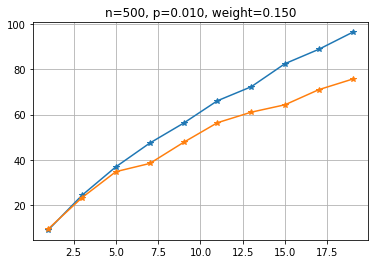

In [169]:
# ER graph
n = 500
# p = np.log(n)/n
p = 0.01
weight=0.15
Env = env(graph_size=n, seed_size=n, p=p, weight=weight)

mu, edge_index, edge_w, node_tag, done = Env.reset()
graph = Data(edge_index = torch.LongTensor(edge_index),
             mu = torch.Tensor(mu),
             edge_w = torch.Tensor(edge_w),
             node_tag = torch.Tensor(node_tag),
             num_nodes = n)

IMM_K = []
Q_K = []
K_range = range(1, 21, 2)
for K in K_range:
    imm_seed, imm_spread = IMM_infer(edge_index, edge_w, K=K)
    q_seed = Q_infer(agent, Env, graph, K=K)

    imm_simu = simulation(edge_index, edge_w, imm_seed, mc=500)
    q_simu = simulation(edge_index, edge_w, q_seed, mc=500)
    print(imm_simu, q_simu)
    
    IMM_K.append((imm_seed, imm_simu))
    Q_K.append((q_seed, q_simu))
    
plt.plot(K_range, [s[1] for s in IMM_K], "-*")
plt.plot(K_range, [s[1] for s in Q_K], "-*")
plt.grid(True)
plt.title("n={}, p={:.3f}, weight={:.3f}".format(n,p, weight))
plt.savefig("comparing_results/n_{}_p_{:.3f}_w_{:.3f}.pdf".format(n, p, weight))
plt.show()



In [178]:
from multiprocessing import Pool
pool = Pool(2)

Process ForkPoolWorker-1:
Traceback (most recent call last):
  File "/home/gaofei/software/anaconda3/envs/dmp_dqn/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process ForkPoolWorker-2:
  File "/home/gaofei/software/anaconda3/envs/dmp_dqn/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/gaofei/software/anaconda3/envs/dmp_dqn/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/gaofei/software/anaconda3/envs/dmp_dqn/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/gaofei/software/anaconda3/envs/dmp_dqn/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/gaofei/software/anaconda3/envs/dmp_dqn/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4

100%|██████████| 500/500 [00:16<00:00, 30.68it/s]


159.62 138.242


100%|██████████| 500/500 [00:16<00:00, 29.88it/s]


220.292 196.272


100%|██████████| 500/500 [00:16<00:00, 29.58it/s]


262.85 219.914


100%|██████████| 500/500 [00:16<00:00, 30.35it/s]


294.992 248.14


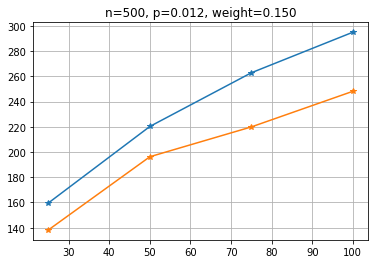

In [202]:
# ER graph
n = 500
p = np.log(n)/n
# p = 0.05
weight=0.15
Env = env(graph_size=n, seed_size=n, p=p, weight=weight)

mu, edge_index, edge_w, node_tag, done = Env.reset()
graph = Data(edge_index = torch.LongTensor(edge_index),
             mu = torch.Tensor(mu),
             edge_w = torch.Tensor(edge_w),
             node_tag = torch.Tensor(node_tag),
             num_nodes = n)


IMM_K = []
Q_K = []
K_range = [25, 50, 75, 100]
for K in K_range:
    imm_seed, imm_spread = IMM_infer(edge_index, edge_w, K=K)
    q_seed = Q_infer(agent, Env, graph, K=K)

    imm_simu = simulation(edge_index, edge_w, imm_seed, mc=500)
    q_simu = simulation(edge_index, edge_w, q_seed, mc=500)
    print(imm_simu, q_simu)
    
    IMM_K.append((imm_seed, imm_simu))
    Q_K.append((q_seed, q_simu))
    
plt.plot(K_range, [s[1] for s in IMM_K], "-*")
plt.plot(K_range, [s[1] for s in Q_K], "-*")
plt.grid(True)
plt.title("n={}, p={:.3f}, weight={:.3f}".format(n,p, weight))
plt.savefig("comparing_results/n_{}_p_{:.3f}_w_{:.3f}.pdf".format(n, p, weight))
plt.show()